In [1]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from pyspark.sql.functions import *
import json
from pyspark.sql.types import *
import urllib.parse
import builtins

spark = sqlContext = SQLContext(sc)

%matplotlib inline

sc.addPyFile("/home/piccardi/libs/tldextract-2.2.1-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/requests_file-1.4.3-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/seaborn-0.9.0-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/idna-2.8-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/validator_collection-1.3.6-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/tokenizer-1.4.0-py3.5.egg")

import tldextract
import seaborn as sns

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
samples_features = spark.read.parquet("link_level_pos_neg_no_ambiguities.parquet")
samples_features

DataFrame[click: boolean, context_text: string, country_code: string, footnote_number: bigint, offset: bigint, page_id: bigint, page_token: string, reference_text: string, revision_id: bigint, quality: map<string,double>, topics: map<string,double>]

In [3]:
samples_features.count()

3627888

In [4]:
samples_features.select("page_id").distinct().count()

601356

In [5]:
samples_features.select("revision_id").distinct().count()

771284

In [6]:
rel_pos = samples_features.select("offset", "click").toPandas()

In [10]:
samples_features

DataFrame[click: boolean, context_text: string, country_code: string, footnote_number: bigint, offset: bigint, page_id: bigint, page_token: string, reference_text: string, revision_id: bigint, quality: map<string,double>, topics: map<string,double>]

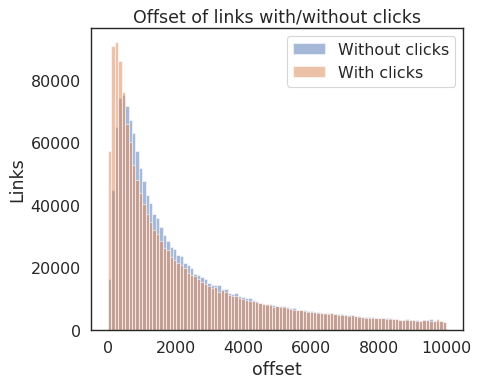

In [9]:
from matplotlib import pyplot
import numpy
import math
from matplotlib.pyplot import figure

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})


figure(num=None, figsize=(6, 5), dpi=80, facecolor='w', edgecolor='k')


bins = numpy.linspace(0, 10000, 100)

pyplot.hist(rel_pos[rel_pos.click==False].offset, bins, alpha=0.5, label='Without clicks')
pyplot.hist(rel_pos[rel_pos.click==True].offset, bins, alpha=0.5, label='With clicks')
pyplot.legend(loc='upper right')
pyplot.title("Offset of links with/without clicks")
pyplot.xlabel("offset")
pyplot.ylabel("Links")
pyplot.show()

# Tokenisation

In [3]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

contextTokenizer = RegexTokenizer(inputCol="context_text", outputCol="context_tokens", pattern="\\W")
referenceTokenizer = RegexTokenizer(inputCol="reference_text", outputCol="reference_tokens", pattern="\\W")

samples_tokenized = contextTokenizer.transform(samples_features)
samples_tokenized = referenceTokenizer.transform(samples_tokenized)

samples_tokenized

DataFrame[click: boolean, context_text: string, country_code: string, footnote_number: bigint, offset: bigint, page_id: bigint, page_token: string, reference_text: string, revision_id: bigint, quality: map<string,double>, topics: map<string,double>, context_tokens: array<string>, reference_tokens: array<string>]

In [4]:
from pyspark.ml.feature import StopWordsRemover

contextRemover = StopWordsRemover(inputCol="context_tokens", outputCol="context_tokens_clean")
referenceRemover = StopWordsRemover(inputCol="reference_tokens", outputCol="reference_tokens_clean")

samples_clean = contextRemover.transform(samples_tokenized).drop("context_tokens")
samples_clean = referenceRemover.transform(samples_clean).drop("reference_tokens")
samples_clean

DataFrame[click: boolean, context_text: string, country_code: string, footnote_number: bigint, offset: bigint, page_id: bigint, page_token: string, reference_text: string, revision_id: bigint, quality: map<string,double>, topics: map<string,double>, context_tokens_clean: array<string>, reference_tokens_clean: array<string>]

In [5]:
import re

is_number = re.compile('^\d+$')

quality_map = {
    'Stub': 0,
    'Start': 1,
    'B': 2,
    'C': 3,
    'GA': 4,
    'FA': 5
}

def get_clean_tokens_vector(tv):
    context_token = []
    for t in tv:
        if len(t)>1:
            if is_number.match(t):
                if len(t) != 4:
                    context_token.append('$number$')
                else:
                    context_token.append(t)
            else:
                context_token.append(t)
    return context_token

def get_topic_quality(row):
    r = row.asDict()
    quality = 0
    if row['quality'] is None:
        quality = -1
    else:
        for k, v in row['quality'].items():
            quality += v*quality_map[k]
    r['quality'] = quality
    if row['quality'] is not None:
        topics = sorted([(t, w) for t, w in row['topics'].items()], key=lambda r: -r[1])
        topic_name = topics[0][0]
        sep_idx = topic_name.index(".")
        top_microtopic = topic_name[sep_idx+1:]
        top_macrotopic = topic_name[:sep_idx]
    else:
        top_microtopic = None
        top_macrotopic = None
        
    r['tokens'] = ["context:"+t for t in get_clean_tokens_vector(r['context_tokens_clean'])] \
                  + ["reference:"+t for t in get_clean_tokens_vector(r['reference_tokens_clean'])]
    r['top_macrotopic'] = top_macrotopic
    r['top_microtopic'] = top_microtopic
    r['click'] = 1 if r['click'] else 0
    del r["topics"]
    del r["context_tokens_clean"]
    del r["reference_tokens_clean"]
    return Row(**r)

samples = spark.createDataFrame(samples_clean.rdd.map(get_topic_quality))
samples

DataFrame[click: bigint, context_text: string, country_code: string, footnote_number: bigint, offset: bigint, page_id: bigint, page_token: string, quality: double, reference_text: string, revision_id: bigint, tokens: array<string>, top_macrotopic: string, top_microtopic: string]

In [6]:
samples.cache().count()

3627888

In [77]:
samples.groupBy("top_macrotopic").agg(count("*")).show()

+-------------------+--------+
|     top_macrotopic|count(1)|
+-------------------+--------+
|         Assistance|    2414|
|               null|  897576|
|            Culture| 1295168|
|               STEM|  435784|
|          Geography|  529584|
|History_And_Society|  467362|
+-------------------+--------+



In [78]:
samples.groupBy("top_microtopic").agg(count("*").alias("total")).sort(col("total").desc()).show(15)

+--------------------+------+
|      top_microtopic| total|
+--------------------+------+
|                null|897576|
|Language and lite...|463236|
|           Countries|375702|
|       Entertainment|172122|
|Business and econ...|168432|
|     Performing arts|165294|
|              Sports|154518|
|          Technology|130726|
|        Broadcasting|114554|
|              Europe|102204|
|            Medicine| 90726|
|Politics and gove...| 86288|
|      Transportation| 75578|
| History and society| 61014|
|    Internet culture| 59218|
+--------------------+------+
only showing top 15 rows



In [18]:
samples.select("context_text", "reference_text", "click", "quality", "top_macrotopic", "top_microtopic")\
.write.json("link_level_pos_neg_clicks.json")

------
# Training

In [85]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression

def print_features_importance(topic_name=None, get_df=False):
    if topic_name is None:
        topic = samples
    else:
        topic = samples.where("top_macrotopic=='{}'".format(topic_name))

    # fit a CountVectorizerModel from the corpus.
    terms_vectorizer = CountVectorizer(inputCol="tokens", 
                                         outputCol="tokens_vector", 
                                         vocabSize=1000)

    context_vectorizer_model = terms_vectorizer.fit(topic)
    result = context_vectorizer_model.transform(topic).cache()
    vocab = context_vectorizer_model.vocabulary
    mlor = LogisticRegression(labelCol="click",featuresCol="tokens_vector", regParam=0.1)
    mlorModel = mlor.fit(result)
    print(mlorModel.summary.areaUnderROC)

    values = mlorModel.coefficients.toArray()
    coeff={}
    for i in range(0, len(vocab)):
        coeff[vocab[i]]=values[i]

    features_importance = pd.DataFrame.from_dict(coeff, orient="index").reset_index()
    features_importance.columns = ["name", "coefficient"]

    context_importance = features_importance[(features_importance.name.str.contains("context"))]\
        .sort_values("coefficient", ascending=False).head(15)

    reference_importance = features_importance[(features_importance.name.str.contains("reference"))]\
        .sort_values("coefficient", ascending=False).head(15)
    
    context_importance_neg = features_importance[(features_importance.name.str.contains("context"))]\
        .sort_values("coefficient", ascending=True).head(15)

    reference_importance_neg = features_importance[(features_importance.name.str.contains("reference"))]\
        .sort_values("coefficient", ascending=True).head(15)

    if get_df:
        return context_importance, reference_importance, context_importance_neg, reference_importance_neg
    else:
        display_side_by_side(context_importance.set_index("name"), reference_importance.set_index("name"),
                     context_importance_neg.set_index("name"), reference_importance_neg.set_index("name")
                    )


In [112]:
print_features_importance("STEM")

0.5814527237246482


,coefficient
name,
context:online,0.247533
context:tests,0.233155
context:2019,0.229767
context:short,0.168988
context:known,0.168856
context:algorithms,0.157724
context:published,0.155067
context:defined,0.154579
context:programming,0.152230


In [113]:
print_features_importance("Culture")

0.5954999145020571


,coefficient
name,
context:article,0.303965
context:born,0.281970
context:greatest,0.269109
context:professional,0.266994
context:died,0.255837
context:known,0.247806
context:ranked,0.242285
context:relationship,0.232219
context:website,0.231762


In [114]:
print_features_importance("History_And_Society")

0.5765953202413084


,coefficient
name,
context:born,0.289998
context:website,0.214881
context:2019,0.206823
context:died,0.196842
context:currently,0.190674
context:known,0.168925
context:referred,0.165314
context:customers,0.158952
context:study,0.155816


In [115]:
print_features_importance("Geography")

0.5789749184084653


,coefficient
name,
context:politician,0.502853
context:born,0.263956
context:magazine,0.249760
context:believed,0.232236
context:married,0.229796
context:ranked,0.224131
context:video,0.220285
context:directed,0.180483
context:crime,0.179973


In [13]:
print_features_importance()

0.5740519537441277


,coefficient
name,
context:greatest,0.363266
context:born,0.279441
context:died,0.231824
context:website,0.226706
context:ranked,0.226333
context:known,0.201965
context:professional,0.190571
context:relationship,0.188371
context:rating,0.180204


In [21]:
context_importance, reference_importance, context_importance_neg, reference_importance_neg = \
        print_features_importance(get_df=True)

0.574037740359786


,coefficient
name,
context:greatest,0.363266
context:born,0.279441
context:died,0.231824
context:website,0.226706
context:ranked,0.226333
context:known,0.201965
context:professional,0.190571
context:relationship,0.188371
context:rating,0.180204
